In [1]:
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms

In [2]:
import numpy as np
import pandas as pd

def generate_ab_data(n=1000, 
                     random_seed=42, 
                     start_date='2021-01-01', 
                     experiment_length=14):
    """
    Generates A/B test data where:
      - Each user is assigned either 'Control' or 'Treatment'.
      - A binary conversion indicator is created.
      - A revenue metric is generated.
      - Each user is randomly assigned a date within the specified experiment_length.
      
    Parameters:
    -----------
    n : int
        Number of users (rows).
    random_seed : int
        Seed for reproducibility.
    start_date : str
        The experiment start date in YYYY-MM-DD format.
    experiment_length : int
        Number of days the experiment will run.
    """
    np.random.seed(random_seed)
    
    # Randomly assign 'Control' or 'Treatment'
    group = np.random.choice(['Control', 'Treatment'], size=n, p=[0.5, 0.5])
    
    # Baseline conversion rates
    conversion_rates = np.where(group == 'Control', 0.30, 0.35)
    
    # Generate binary outcome (Converted / Not Converted)
    converted = np.random.binomial(n=1, p=conversion_rates, size=n)
    
    # Continuous metric, e.g., revenue
    revenue = np.where(group == 'Control',
                       np.random.normal(loc=50, scale=10, size=n),
                       np.random.normal(loc=55, scale=10, size=n))
    
    # Create a range of dates covering the full experiment length
    # For example, if experiment_length=14, this covers from start_date to start_date + 13 days
    date_range = pd.date_range(start=start_date, periods=experiment_length, freq='D')
    
    # Randomly assign each user to one of these days
    assigned_dates = np.random.choice(date_range, size=n)
    
    df_ab = pd.DataFrame({
        'user_id': range(1, n+1),
        'group': group,
        'converted': converted,
        'revenue': revenue,
        'date': assigned_dates
    })
    
    return df_ab

# Example usage:
df_ab = generate_ab_data(n=1000, start_date='2021-01-01', experiment_length=14)
print(df_ab)

     user_id      group  converted    revenue       date
0          1    Control          0  41.220174 2021-01-01
1          2  Treatment          0  58.896142 2021-01-12
2          3  Treatment          1  46.317073 2021-01-09
3          4  Treatment          1  60.346291 2021-01-02
4          5    Control          1  59.135846 2021-01-09
..       ...        ...        ...        ...        ...
995      996    Control          0  44.352260 2021-01-13
996      997  Treatment          1  43.884198 2021-01-12
997      998    Control          0  70.884428 2021-01-06
998      999  Treatment          0  49.685454 2021-01-12
999     1000    Control          0  31.200756 2021-01-10

[1000 rows x 5 columns]


In [3]:
# check how many observations are in each group
df_ab['group'].value_counts()

group
Control      503
Treatment    497
Name: count, dtype: int64

<Axes: xlabel='date'>

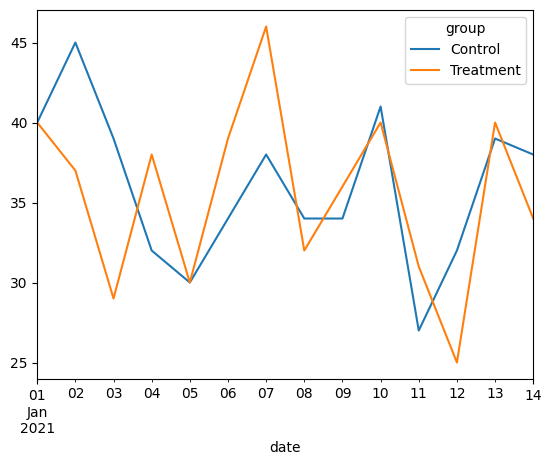

In [28]:
# plot the number of observations in each group over time
df_ab.groupby('date')['group'].value_counts().unstack().plot()

In [4]:
# summarize conversion rate and revenue by group
df_ab.groupby('group')[['converted', 'revenue']].mean()

,converted,revenue
group,,
Control,0.304175,50.353329
Treatment,0.362173,54.804776


In [5]:
# use statsmodels to calculate p-value for conversion rate
# Statistical Analysis for Conversion Rate
control_conversions = df_ab[df_ab['group'] == 'Control']['converted']
treatment_conversions = df_ab[df_ab['group'] == 'Treatment']['converted']

# Calculate conversion rate statistics using statsmodels
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Count successes and sample sizes for each group
count_control = control_conversions.sum()
count_treatment = treatment_conversions.sum()
nobs_control = len(control_conversions)
nobs_treatment = len(treatment_conversions)

# Perform z-test for conversion rates
counts = np.array([count_treatment, count_control])
nobs = np.array([nobs_treatment, nobs_control])
stat, pvalue = proportions_ztest(counts, nobs)

# Calculate confidence intervals
ci_treatment = proportion_confint(count_treatment, nobs_treatment)
ci_control = proportion_confint(count_control, nobs_control)

print("\nConversion Rate Analysis:")
print(f"Control Group: {count_control/nobs_control:.4f} [{ci_control[0]:.4f}, {ci_control[1]:.4f}]")
print(f"Treatment Group: {count_treatment/nobs_treatment:.4f} [{ci_treatment[0]:.4f}, {ci_treatment[1]:.4f}]")
print(f"P-value: {pvalue:.4f}")


Conversion Rate Analysis:
Control Group: 0.3042 [0.2640, 0.3444]
Treatment Group: 0.3622 [0.3199, 0.4044]
P-value: 0.0517


In [6]:
# Statistical Analysis for Revenue
from scipy import stats

control_revenue = df_ab[df_ab['group'] == 'Control']['revenue']
treatment_revenue = df_ab[df_ab['group'] == 'Treatment']['revenue']

# Perform t-test for revenue
t_stat, p_value = stats.ttest_ind(treatment_revenue, control_revenue)

# Calculate confidence intervals for mean revenue
def mean_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    se = stats.sem(data)
    ci = stats.t.interval(confidence, len(data)-1, loc=mean, scale=se)
    return mean, ci

control_mean, control_ci = mean_confidence_interval(control_revenue)
treatment_mean, treatment_ci = mean_confidence_interval(treatment_revenue)

print("\nRevenue Analysis:")
print(f"Control Group Mean: ${control_mean:.2f} [${control_ci[0]:.2f}, ${control_ci[1]:.2f}]")
print(f"Treatment Group Mean: ${treatment_mean:.2f} [${treatment_ci[0]:.2f}, ${treatment_ci[1]:.2f}]")
print(f"P-value: {p_value:.4f}")


Revenue Analysis:
Control Group Mean: $50.35 [$49.47, $51.24]
Treatment Group Mean: $54.80 [$53.93, $55.68]
P-value: 0.0000


<Axes: title={'center': 'Conversion Rates Over Time'}, xlabel='date', ylabel='Conversion Rate'>

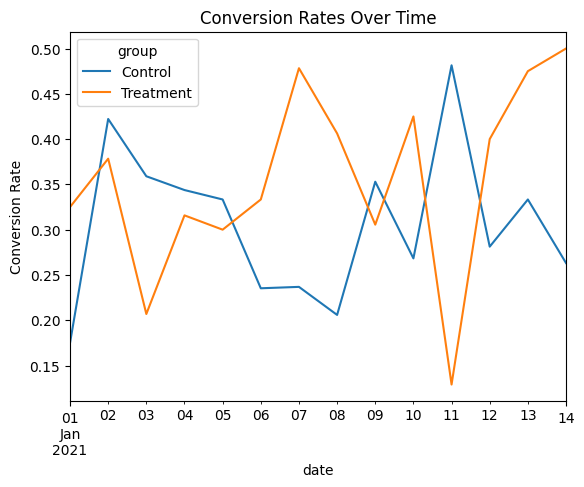

In [8]:
# Plot conversion rates over time
conversion_rates_over_time = df_ab.groupby(['date', 'group'])['converted'].mean().unstack()
conversion_rates_over_time.plot(title='Conversion Rates Over Time', ylabel='Conversion Rate')

<Axes: title={'center': 'Average Revenue Over Time'}, xlabel='date', ylabel='Average Revenue ($)'>

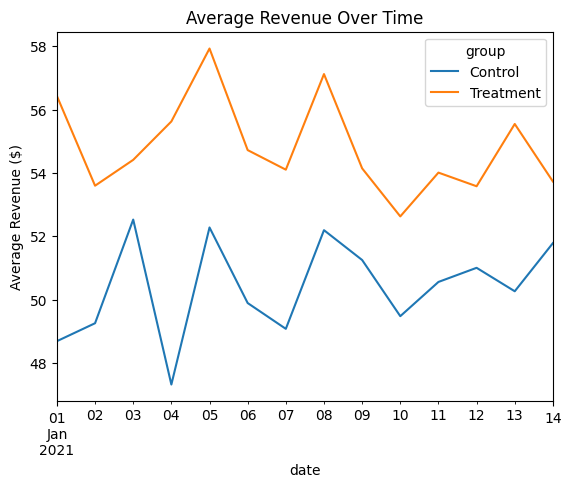

In [9]:
# Plot revenue over time
revenue_over_time = df_ab.groupby(['date', 'group'])['revenue'].mean().unstack()
revenue_over_time.plot(title='Average Revenue Over Time', ylabel='Average Revenue ($)')